In [1]:
from pyro.nn import AutoRegressiveNN
from pyro import distributions
import pyro, torch
import numpy as np
import matplotlib.pyplot as plt
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
%matplotlib inline

from torch.distributions.multivariate_normal import MultivariateNormal as mvn
import seaborn as sns

import torch.nn as nn

torch.manual_seed(0)
np.random.seed(0)

class NormalizingFlow(nn.Module):
    def __init__(self,dim,
                      n_flows,
                     base_dist=lambda dim:distributions.Normal(torch.zeros(dim), torch.ones(dim)),
                     flow_type=lambda kwargs:distributions.transforms.RadialFlow(**kwargs),
                     args={'flow_args':{'dim':2}}):
        super(NormalizingFlow, self).__init__()
        self.dim = dim
        self.n_flows = n_flows
        self.base_dist = base_dist(dim)
        
        
        
        if 'arn_hidden' in args:
            self.arns = nn.ModuleList([AutoRegressiveNN(dim,
                                                        args['arn_hidden'],
                                                        param_dims=[self.dim]*args['n_params']) for _ in range(n_flows)])
#         self.nfs = ([distributions.transforms.InverseAutoregressiveFlow(self.arns[f]) for f in range(n_flows)])
    
        self.nfs = []
        for f in range(n_flows):
            if 'autoregressive_nn' in args['flow_args']:
                args['flow_args']['autoregressive_nn'] = self.arns[f]
            nf = flow_type(args['flow_args'])
            self.nfs.append(nf)
#         self.nfs = [distributions.transforms.NeuralAutoregressive(self.arns[f], hidden_units=512) for f in range(n_flows)]

        self.nf_dist = distributions.TransformedDistribution(self.base_dist, self.nfs)

    def model(self,x,p_z):
        with pyro.plate("data", x.shape[0]):
            p = p_z()
            z = pyro.sample("latent",p)
            
            pyro.sample("obs", p, obs=x.reshape(-1, self.dim))
        
    def guide(self,x,p_z):
        for f in range(self.n_flows):
            nf_module = pyro.module("nf_%d" %(f), self.nfs[f])
        with pyro.plate("data", x.shape[0]):
            pyro.sample("latent", self.nf_dist)

    def sample(self,n):
        return self.nf_dist.sample(torch.Size([n]))
    
    def log_prob(self,z):
        return self.nf_dist.log_prob(z)

flow = distributions.transforms.NeuralAutoregressive
base_dist = lambda dim:distributions.Normal(torch.zeros(dim), torch.ones(dim))
dim = 2
n_flows = 2
if 'InverseAutoregressiveFlow' in flow.__name__:
    args = {'arn_hidden':[64],
            'n_params': 2,
            'flow_args':{'autoregressive_nn':None}
            }
    
elif flow.__name__ == 'NeuralAutoregressive':
    args = {'arn_hidden':[64],
                 'n_params': 3,
                 'flow_args':{'hidden_units':512,'autoregressive_nn':None}
           }
elif flow.__name__ in ['PlanarFlow','RadialFlow']:
    args = {'flow_args':{'input_dim':dim}}
else:
    raise('Flow not found')
    
nf_obj = NormalizingFlow(dim=dim,
                      n_flows=n_flows,
                     base_dist=base_dist,
                     flow_type=lambda kwargs:flow(**kwargs),
                     args=args)

/Users/bmazoure/anaconda3/envs/pytorch_latest/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/Users/bmazoure/anaconda3/envs/pytorch_latest/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


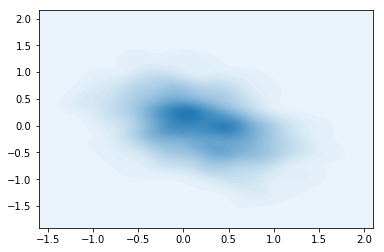

In [2]:
samples = nf_obj.sample(1000).numpy()

sns.kdeplot(data=samples,n_levels=60, shade=True)
plt.show()

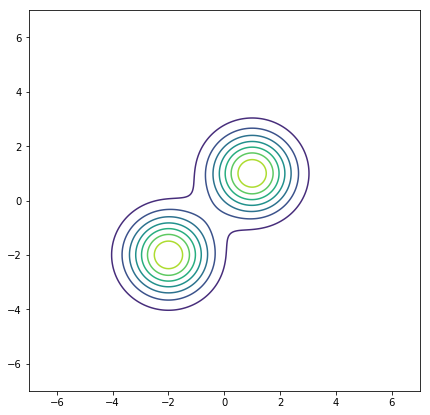

In [3]:
def p_z(mu1=torch.FloatTensor([1,1]),mu2=torch.FloatTensor([-2,-2])):

    Sigma1 = torch.FloatTensor([1,1])
    Sigma2 = torch.FloatTensor([1,1])
    component_logits = torch.FloatTensor([0.5,0.5])
    
    dist = distributions.MixtureOfDiagNormals(locs=torch.stack([mu1,mu2],axis=0),
                                       coord_scale=torch.stack([Sigma1,Sigma2],axis=0),
                                       component_logits=component_logits)
    return dist
#     mvn1 = mvn(mu1,Sigma1)
#     mvn2 = mvn(mu2,Sigma2)
    
#     exp1 = mvn1.log_prob(z).exp()
#     exp2 = mvn2.log_prob(z).exp()

    
#     u = 0.5 * exp1 + 0.5 * exp2
    
#     return u

def plot_density(density):

    X_LIMS = (-7, 7)
    Y_LIMS = (-7, 7)

    x1 = np.linspace(*X_LIMS, 300)
    x2 = np.linspace(*Y_LIMS, 300)
    x1, x2 = np.meshgrid(x1, x2)
    shape = x1.shape
    x1 = x1.ravel()
    x2 = x2.ravel()

    z = np.c_[x1, x2]
    z = torch.FloatTensor(z)
    
    density_values = density(z).data.numpy().reshape(shape)

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    ax.contour(density_values, extent=(*X_LIMS, *Y_LIMS), cmap="viridis")
    plt.show()
    
plot_density(lambda z:p_z().log_prob(z).exp())

In [4]:
adam_params = {"lr": 0.005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(nf_obj.model, nf_obj.guide, optimizer, loss=Trace_ELBO())
n_steps = 100
dist = p_z()
# do gradient steps
losses = []
for step in range(n_steps):
    data = dist.rsample(torch.Size([128]))
    loss = svi.step(data,p_z)
    losses.append(loss)
    if step % 100 == 0:
        print(loss)

700.8755798339844


/Users/bmazoure/anaconda3/envs/pytorch_latest/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


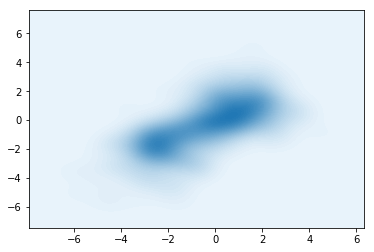

In [5]:
samples = nf_obj.sample(500).numpy()

sns.kdeplot(data=samples,n_levels=60, shade=True)
plt.show()